In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from  shutil import copyfile
import random
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
# This code block unzips the full Cats-v-Dogs dataset to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
# path_cats_and_dogs ='C:\\Data\\CV\\dogs-vs-cats.zip'


# local_zip = path_cats_and_dogs
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('C:\\Data\\CV\\dogs-vs-cats\\')
# zip_ref.close()

In [ ]:
test_path_cats_and_dogs ='../input/dogs-vs-cats/test1.zip'


local_zip = test_path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./cats-vs-dogs/')
zip_ref.close()

In [ ]:
train_path_cats_and_dogs ='../input/dogs-vs-cats/train.zip'


local_zip = train_path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./cats-vs-dogs/')
zip_ref.close()

In [ ]:
BASE_PATH = './cats-vs-dogs/train/'
TRAIN_PATH='./cats-vs-dogs/train_data/'
VAL_PATH='./cats-vs-dogs/validation_data/'

In [ ]:

try:
    shutil.rmtree(TRAIN_PATH)
    shutil.rmtree(VAL_PATH)
except:
    print("Directory does not exists")

In [ ]:
os.mkdir(TRAIN_PATH)
os.mkdir(VAL_PATH)
train_dog=os.path.join(TRAIN_PATH , 'dog')
train_cat=os.path.join(TRAIN_PATH , 'cat')
val_dog=os.path.join(VAL_PATH , 'dog')
val_cat=os.path.join(VAL_PATH , 'cat')
# print(train_cat)
os.mkdir(train_dog)
os.mkdir(train_cat)
os.mkdir(val_dog)
os.mkdir(val_cat)

In [ ]:
#segregating cats and dog files for training and validation
cat_file_list=[]
dog_file_list=[]
for file in os.listdir(BASE_PATH):
    if file[:3]=='cat':
        cat_file_list.append(file)
    elif file[:3]=='dog':
        dog_file_list.append(file)
#shuffling the list


In [ ]:
train_split=0.8

random.sample(cat_file_list, len(cat_file_list))
random.sample(dog_file_list, len(dog_file_list))
num_of_training_files_cat= int(len(cat_file_list)* train_split)
num_of_training_files_dog= int(len(dog_file_list)* train_split)
print("Total training cat files", num_of_training_files_cat)
print("Training files dog", num_of_training_files_dog)
print("Total filess", len(cat_file_list) + len(dog_file_list) )
print("Total val Dog files", len(dog_file_list) - num_of_training_files_dog)

for file in cat_file_list[:num_of_training_files_cat]:
   copyfile(os.path.join(BASE_PATH, file), os.path.join(train_cat, file))
   
for file in cat_file_list[num_of_training_files_cat:]:
   copyfile(os.path.join(BASE_PATH, file), os.path.join(val_cat, file))

for file in dog_file_list[:num_of_training_files_dog]:
   copyfile(os.path.join(BASE_PATH, file), os.path.join(train_dog, file))
   
for file in dog_file_list[num_of_training_files_dog:]:
   copyfile(os.path.join(BASE_PATH, file), os.path.join(val_dog, file))
    
    

In [ ]:
print("Total val Dog files", len(dog_file_list) - num_of_training_files_dog)

In [ ]:
batch_size = 128 #128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
train_image_generator = ImageDataGenerator(
                                                rescale=1./255,
                                                rotation_range=45,
                                                width_shift_range=.15,
                                                height_shift_range=.15,
                                                horizontal_flip=True,
                                                zoom_range=0.3                         

                                            ) # Generator for our training data

In [ ]:
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=TRAIN_PATH,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=VAL_PATH,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
plotImages(sample_training_images[:5])

In [ ]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [ ]:
model.summary()

In [ ]:

batch_size=100
history = model.fit_generator(
    train_data_gen,

    epochs=10,
    validation_data=val_data_gen,
)

In [ ]:
while True:
    pass

In [ ]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
img_path='./cats-vs-dogs/train_data/cat/cat.9999.jpg' #dog

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0
y_pred=model.predict(x)
#_pred =(y_pred>0.5)
print(y_pred)

In [ ]:
train_data_gen.class_indices

In [ ]:
def plotFilters(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip( conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# for layer in model.layers:
#     if 'conv' in layer.name:
#         filters, bias= layer.get_weights()
#         print(layer.name, filters.shape)
#          #normalize filter values between  0 and 1 for visualization
#         f_min, f_max = filters.min(), filters.max()
#         filters = (filters - f_min) / (f_max - f_min)  
#         print(filters.shape[3])
#         axis_x=1
#         #plotting all the filters
#         for i in range(filters.shape[3]):
#         #for i in range(6):
#             #get the filters
#             filt=filters[:,:,:, i]
#             plotFilters(filt)

In [ ]:
# #Visualizing the filters
# #plt.figure(figsize=(5,5))
# for layer in model.layers:
#     if 'conv' in layer.name:
#         weights, bias= layer.get_weights()
#         print(layer.name, weights.shape)
#          #normalize filter values between  0 and 1 for visualization
#         f_min, f_max = weights.min(), weights.max()
#         filters = (weights - f_min) / (f_max - f_min)  
#         print(weights.shape[3])
#         filter_cnt=1
#         #plotting all the filters
#         for i in range(filters.shape[3]):
#         #for i in range(6):
#             #get the filters
#             filt=filters[:,:,:, i]
#             #plotting ecah channel
#             for j in range(filters.shape[0]):
#                 #plt.figure( figsize=(5, 5) )
#                 #f = plt.figure(figsize=(10,10))
#                 ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 plt.imshow(filt[:,:, j])
#                 filter_cnt+=1
#         plt.show()
        

In [ ]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

In [ ]:

img_path='./cats-vs-dogs/train_data/dog/dog.10000.jpg' #dog
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
#cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
#dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]

#img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

In [ ]:
img_path='./cats-vs-dogs/train_data/cat/cat.9999.jpg' #dog
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(150, 150))  
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)                   
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x 

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [ ]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']

# loss=history.history['loss']
# val_loss=history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
model.save('./model1.h5')

# Grab Cam - Visual Explanations from Deep Networks

Research Paper : https://arxiv.org/abs/1610.02391 

Papers with code : https://paperswithcode.com/paper/grad-cam-visual-explanations-from-deep

<img src="https://camo.githubusercontent.com/ffae15bf007544c9e651f1744157b8eeb2603e17bb8d5c24ba6411bbc5b236c2/687474703a2f2f692e696d6775722e636f6d2f4a614762645a352e706e67">


In [ ]:
from IPython.display import HTML

HTML('<div align="center"><iframe align = "middle" width="790" height="440" src="https://www.youtube.com/watch?v=COjUB9Izk6E" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div>')

In [8]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras

In [ ]:
model_builder = tf.keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

# The local path to our target image
img_path = tf.keras.utils.get_file(
    "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
)

display(Image(img_path))

# The Grad-CAM algorithm

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Testing

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

In [ ]:
img_path = keras.utils.get_file(
    "cat_and_dog.jpg",
    "https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg",
)

display(Image(img_path))

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the two top predicted classes are
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=2)[0])

In [ ]:
#We generate class activation heatmap for "chow," the class index is 260
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=260)

save_and_display_gradcam(img_path, heatmap)

In [ ]:
#We generate class activation heatmap for "egyptian cat," the class index is 285
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=285)

save_and_display_gradcam(img_path, heatmap)

# TF-Explain : A Tensorflow 2.0 library for deep learning model interpretability.

The library is adapted to the Tensorflow 2.0 workflow, using tf.keras API as possible. It provides:

- Heatmaps Visualizations & Gradients Analysis
- Both off-training and tf.keras.Callback Usages
- Tensorboard Integration

<img src="https://d37oebn0w9ir6a.cloudfront.net/account_16771/3_5c0602cf4b164e4fa33cbdf351fde838.gif">

## Why Interpretability?

The main challenge when working with deep neural networks is **to understand the behavior of trained networks** . It is crucial both to the scientist to debug and improve current model, and to the users **to help them to trust the method**. As a human, it is difficult to get feedback from a neural network. Interpretability has emerged in research to help tackling this:

- Analysis of decisions over a validation set helps identify issues with the network (for instance bias in dataset, mislabeled data)
- Heatmap visualizations are often appreciated by non-initiated users

However, those methods are not well-integrated in deep learning workflow as of today.

### The solution: off the shelf analysis tools for your tf.keras models
tf-explain implements interpretability methods as Tensorflow 2.0 callbacks to ease neural networks’ understanding.

The library was built to offer a comprehensive list of interpretability methods, directly usable in your Tensorflow workflow



There are two Methods for using tf-explain with can be represeted such as : 
- After the model is trained to check the explanation of model 
- During model trainig in the form of Callbacks in TensorFlow



In [4]:
pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 385.4 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# from tensorflow import keras
# model = keras.models.load_model('../input/ml-models/model1.h5')

2022-08-13 08:19:18.233694: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
from tf_explain.core import *

# Load pretrained model or your own
model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)
IMAGE_PATH = "../input/dogs-cats-images/dataset/training_set/dogs/dog.100.jpg"
# Load a sample image (or multiple ones)
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=281)  # 281 is the tabby cat index in ImageNet

explainer.save(grid, ".", "grad_cam.png")
display(Image(IMAGE_PATH))
display(Image("grad_cam.png"))

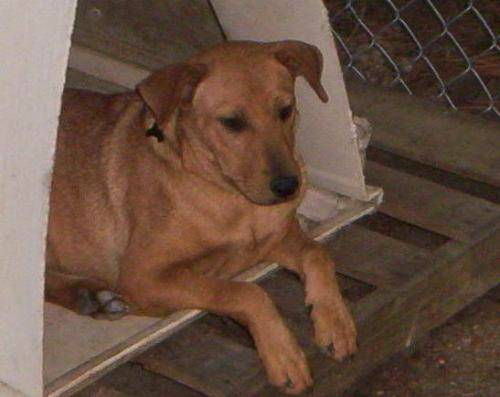

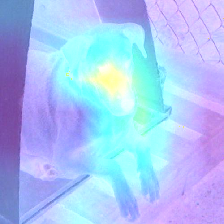